In [1]:
import numpy as np
import re
import os
import random
import cv2
from imgaug import augmenters as iaa

import tensorflow as tf

target_shape = (96, 96)
BATCH_SIZE = 256
images_path = os.getcwd() + "\Dataset"

In [2]:
def preprocess_image(filename):
    """
    Load the specified file as a BMP image, preprocess it and
    resize it to the target shape.
    """
    img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, target_shape)
    img = np.expand_dims(img, axis=-1)
    img = img.astype(np.float32) /255.
    return img

In [3]:
from sklearn.model_selection import train_test_split

dicImages = {}
dataset_x = []; dataset_y = []
for dirs in os.listdir(images_path):
    for f in os.listdir(images_path+'\\'+dirs):
        fClass = int(re.findall('[0-9]+', f)[0])
        dataset_x.append(images_path+'\\'+dirs+'\\'+f)
        dataset_y.append(fClass)
        if(dirs == "Real"):
            dicImages.setdefault(fClass,[]).append(images_path+'\\'+dirs+'\\'+f)
    
dataset_x = np.array(dataset_x)
dataset_y = np.array(dataset_y)
    
x_train, x_val, label_train, label_val = train_test_split(dataset_x, dataset_y, test_size=0.1)

print(dataset_x.shape, dataset_y.shape)
print(x_train.shape, label_train.shape)
print(x_val.shape, label_val.shape)

del(dataset_x)
del(dataset_y)

(55270,) (55270,)
(49743,) (49743,)
(5527,) (5527,)


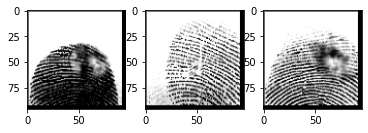

In [6]:
import matplotlib.pyplot as plt

plt.subplot(1,3,1)
plt.imshow(preprocess_image(random.choice(x_train)), cmap='gray')

plt.subplot(1,3,2)
plt.imshow(preprocess_image(random.choice(x_train)), cmap='gray')

plt.subplot(1,3,3)
plt.imshow(preprocess_image(random.choice(x_train)), cmap='gray')

In [4]:
from sklearn.utils import shuffle

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, x, label, dicImages, batch_size=32, shuffle=True):
        'Initialization'
        self.x = x
        self.label = label
        self.label_dict = dicImages
        
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return len(self.x) // self.batch_size

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        x1_batch_tmp = self.x[index*self.batch_size:(index+1)*self.batch_size]
        x1_batch = []
        for f in x1_batch_tmp: x1_batch.append(preprocess_image(f))
        x1_batch = np.array(x1_batch)
        label_batch = self.label[index*self.batch_size:(index+1)*self.batch_size]
        
        x2_batch = np.empty((self.batch_size, 96, 96, 1), dtype=np.float32)
        y_batch = np.zeros((self.batch_size, 1), dtype=np.float32)
        
        # augmentation
        if self.shuffle:
            seq = iaa.Sequential([
                iaa.GaussianBlur(sigma=(0, 0.5)),
                iaa.Affine(
                    scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
                    translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
                    rotate=(-30, 30),
                    order=[0, 1],
                    cval=255
                )
            ], random_order=True)

            x1_batch = seq.augment_images(x1_batch)
        
        # pick matched images(label 1.0) and unmatched images(label 0.0) and put together in batch
        for i, key in enumerate(label_batch):
            if random.random() > 0.5:
                # put matched image
                x2_batch[i] = preprocess_image(random.choice(self.label_dict[key]))
                while((x2_batch[i]==x1_batch[i]).all()):
                    x2_batch[i] = preprocess_image(random.choice(self.label_dict[key]))
                y_batch[i] = 1.
            else:
                # put unmatched image
                tmp = random.choice(self.label)
                while(tmp == key): tmp = random.choice(self.label)
                x2_batch[i] = preprocess_image(random.choice(self.label_dict[tmp]))
                y_batch[i] = 0.
                
        return [x1_batch, x2_batch], y_batch

    def on_epoch_end(self):
        if self.shuffle == True:
            self.x, self.label = shuffle(self.x, self.label)

In [5]:
train_gen = DataGenerator(x_train, label_train, dicImages, batch_size=BATCH_SIZE, shuffle=True)
val_gen = DataGenerator(x_val, label_val, dicImages, batch_size=BATCH_SIZE, shuffle=False)

In [6]:
from tensorflow.keras import layers
from tensorflow.keras import Model

def Get_Model():
    
    # 1 Basic model for embeddings
    inputs = layers.Input(shape=(target_shape + (1,)))
    feature = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(inputs)
    feature = layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(feature)
    feature = layers.MaxPooling2D(pool_size=2)(feature)
    feature = layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')(feature)
    feature = layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')(feature)
    feature = layers.MaxPooling2D(pool_size=2)(feature)

    feature_model = Model(inputs=inputs, outputs=feature)
    
    # 2 feature models that sharing weights
    inp1 = layers.Input(shape=(target_shape + (1,)))
    inp2 = layers.Input(shape=(target_shape + (1,)))
    inp1_net = feature_model(inp1)
    inp2_net = feature_model(inp2)
    net = layers.Subtract()([inp1_net, inp2_net]) # subtract features
    net = layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')(net)
    net = layers.MaxPooling2D(pool_size=2)(net)
    net = layers.Flatten()(net)
    net = layers.Dense(256, activation='relu')(net)
    net = layers.Dense(128, activation='relu')(net)
    net = layers.Dense(1, activation='sigmoid')(net)
    
    model = Model(inputs=[inp1, inp2], outputs=net)
    model.summary()

    return model

model = Get_Model()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 96, 96, 1)]  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 96, 96, 1)]  0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 24, 24, 64)   64992       input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
subtract (Subtract)             (None, 24, 24, 64)   0           model[0][0]                

In [30]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001*10e-1),
    loss='binary_crossentropy',
    metrics=['acc'])

history = model.fit(
    x=train_gen,
    validation_data=val_gen,
    epochs=25)

Epoch 1/25
194/194 [==============================] - 217s 1s/step - loss: 0.3209 - accuracy: 0.8575 - val_loss: 0.3723 - val_accuracy: 0.8253
Epoch 2/25
194/194 [==============================] - 218s 1s/step - loss: 0.3269 - accuracy: 0.8536 - val_loss: 0.3323 - val_accuracy: 0.8495
Epoch 3/25
194/194 [==============================] - 218s 1s/step - loss: 0.3190 - accuracy: 0.8578 - val_loss: 0.3173 - val_accuracy: 0.8584
Epoch 4/25
194/194 [==============================] - 218s 1s/step - loss: 0.3202 - accuracy: 0.8587 - val_loss: 0.3284 - val_accuracy: 0.8510
Epoch 5/25
194/194 [==============================] - 218s 1s/step - loss: 0.3153 - accuracy: 0.8600 - val_loss: 0.3316 - val_accuracy: 0.8460
Epoch 6/25
194/194 [==============================] - 218s 1s/step - loss: 0.3181 - accuracy: 0.8600 - val_loss: 0.3546 - val_accuracy: 0.8358
Epoch 7/25
194/194 [==============================] - 218s 1s/step - loss: 0.3241 - accuracy: 0.8578 - val_loss: 0.3561 - val_accuracy: 0.8358

In [58]:
model.save_weights('fingerprint_weight.h5')

In [15]:
model.load_weights('fingerprint_weight.h5')

In [59]:
img1 = preprocess_image('Dataset/Real/2__F_Left_little_finger.BMP')
img1 = np.expand_dims(img1, axis=0)
img2 = preprocess_image('Dataset/Real/4__M_Left_index_finger.BMP')
img2 = np.expand_dims(img2, axis=0)
test = [img2, img1] #1: Whatever / 2: Real
pred = model.predict(test)
print(pred)

def testAccuracy(img, cl):
    error = 0
    for f in os.listdir('Dataset/Real'):
        fClass = int(re.findall('[0-9]+', f)[0])
        img2 = preprocess_image('Dataset/Real/'+f)
        img2 = np.expand_dims(img2, axis=0)
        test = [img2, img]
        pred = model.predict(test)
        if(fClass == cl and pred < 0.5): print(pred)
        if(pred > 0.5 and fClass != cl):
            #print(str(f) + ' : ' + str(pred))
            error+=1
            #if(error >= 50): break
    print((error/6000)*100)
    
    
testAccuracy(img1, 2)

[[3.410385e-05]]
16.3


In [60]:
img1 = preprocess_image('Dataset/Real/3__M_Left_index_finger.BMP')
img1 = np.expand_dims(img1, axis=0)
img2 = preprocess_image('Dataset/Real/117__F_Left_index_finger.BMP')
img2 = np.expand_dims(img2, axis=0)
test = [img2, img1] #1: Whatever / 2: Real
pred = model.predict(test)
print(pred)

testAccuracy(img1, 3)

[[0.00301469]]
10.233333333333333
